In [468]:
%matplotlib inline 
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import glob
import random
import re
import time
import math
import os
from sklearn.utils import shuffle

In [455]:
def load_drawings(base_path='datasets/quickdraw'):
    categories = glob.glob(base_path + '/*')
    X = []
    CATEGORIES = {}
    drawing_cat_str = []
    drawing_cat_id = []
    drawing_id = []
    drawing_t = []
    X_index = []
    
    for cat_i, cat in enumerate(sorted(categories)):
        CATEGORIES[cat_i] = cat.split('/')[-1]
        paths = glob.glob(cat + '/*')
        for p in paths:
            # Generate array from img
            im = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
            im = im / 255.
            X.extend(np.array([im]))
            
            # Drawing data
            drawing_cat_id.append(cat_i)
            drawing_cat_str.append(CATEGORIES[cat_i])
            match = re.match(r'.*/{}-(\d*)-(\d*).png'.format(CATEGORIES[cat_i]), p)
            drawing_id.append(int(match.group(1)))
            drawing_t.append(int(match.group(2)))
            X_index.append(len(X)-1)


    info_df = pd.DataFrame({'drawing_cat_id': drawing_cat_id, 
                            'drawing_cat_str': drawing_cat_str,
                            'drawing_id': drawing_id,
                            't': drawing_t,
                            'X_index': X_index})


    
    # Replicate last image
    MAX_T = info_df['t'].max()
    g = info_df.groupby(by=['drawing_cat_id', 'drawing_id'])
    for key, df in g:
        max_row = (df[df['t'] == df['t'].max()])
        
        drawing_cat_str = []
        drawing_cat_id = []
        drawing_id = []
        drawing_t = []    
        X_index = []    
        
        for i in range(df['t'].max() + 1, MAX_T + 1):
            drawing_cat_id.append(int(max_row['drawing_cat_id'].values[0]))
            drawing_cat_str.append(max_row['drawing_cat_str'].values[0])
            drawing_id.append(int(max_row['drawing_id'].values[0]))
            X.extend([X[int(max_row['X_index'].values[0])]])
            X_index.append(len(X)-1)
            drawing_t.append(i)            

        appendix = pd.DataFrame({'drawing_cat_id': drawing_cat_id, 
                                 'drawing_cat_str': drawing_cat_str,
                                 'drawing_id': drawing_id,
                                 't': drawing_t,
                                 'X_index': X_index})
        info_df = info_df.append(appendix)
    
    X, info_df = shuffle(X, info_df, random_state=0)
    info_df['X_index'] = info_df.index
    info_df.index = range(len(info_df))
    info_df['X_index'] = range(len(info_df))    
    return X, info_df, CATEGORIES


In [456]:
X, info_df, CATEGORIES = load_drawings()

# Flatten Nx28x28 -> Nx784x1
N = len(X)
# np.reshape(X, (len(X), 1, 784))
X_flat = np.reshape(np.ravel(X), (N, -1))
len(X), len(info_df), CATEGORIES

(53400,
 53400,
 {0: 'airplane',
  1: 'banana',
  2: 'baseball',
  3: 'bicycle',
  4: 'carrot',
  5: 'cello'})

In [458]:
info_df.head()

,X_index,drawing_cat_id,drawing_cat_str,drawing_id,t
0,0,5.0,cello,113947.0,41.0
1,1,4.0,carrot,41438.0,42.0
2,2,3.0,bicycle,102801.0,24.0
3,3,4.0,carrot,94260.0,79.0
4,4,3.0,bicycle,18402.0,58.0


In [118]:
info_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53400 entries, 2 to 2732
Data columns (total 5 columns):
X_index            53400 non-null float64
drawing_cat_id     53400 non-null float64
drawing_cat_str    53400 non-null object
drawing_id         53400 non-null float64
t                  53400 non-null float64
dtypes: float64(4), object(1)
memory usage: 2.4+ MB


In [103]:
# # Replicate last image
# MAX_T = info_df['t'].max()
# g = info_df.groupby(by=['drawing_cat_id', 'drawing_id'])
# for key, df in g:
# #     print(key)
# #     print(df)
#     max_row = (df[df['t'] == df['t'].max()])
# #     print(max_row)

#     drawing_cat_str = []
#     drawing_cat_id = []
#     drawing_id = []
#     drawing_t = []    
#     X_index = []    
#     for i in range(df['t'].max() + 1, MAX_T + 1):
#         drawing_cat_id.append(int(max_row['drawing_cat_id'].values[0]))
#         drawing_cat_str.append(max_row['drawing_cat_str'].values[0])
#         drawing_id.append(int(max_row['drawing_id'].values[0]))
#         X_index.append(int(max_row['X_index'].values[0]))
#         drawing_t.append(i)    

#     appendix = pd.DataFrame({'drawing_cat_id': drawing_cat_id, 
#                              'drawing_cat_str': drawing_cat_str,
#                              'drawing_id': drawing_id,
#                              't': drawing_t,
#                              'X_index': X_index})
#     info_df = info_df.append(appendix)

    
# display(info_df)
    

/home/eduardo/.local/share/virtualenvs/ae-dyn-projection-VDVViZLp/lib/python3.5/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,X_index,drawing_cat_id,drawing_cat_str,drawing_id,t
0,14480.0,4.0,carrot,125992.0,13.0
1,14844.0,4.0,carrot,118507.0,7.0
2,2743.0,0.0,airplane,88954.0,24.0
3,15128.0,4.0,carrot,45296.0,4.0
4,14425.0,4.0,carrot,41505.0,22.0
5,17696.0,5.0,cello,100221.0,3.0
6,88.0,0.0,airplane,76238.0,20.0
7,4309.0,1.0,banana,48257.0,4.0
8,20517.0,5.0,cello,113947.0,15.0
9,1043.0,0.0,airplane,76513.0,0.0


In [104]:
info_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53400 entries, 0 to 41
Data columns (total 5 columns):
X_index            53400 non-null float64
drawing_cat_id     53400 non-null float64
drawing_cat_str    53400 non-null object
drawing_id         53400 non-null float64
t                  53400 non-null float64
dtypes: float64(4), object(1)
memory usage: 2.4+ MB


In [119]:
max_row['drawing_cat_id']

1296    5
Name: drawing_cat_id, dtype: int64

In [121]:
np.save('X.npy', X)
info_df.to_pickle('info_df.pkl')
np.save('CATEGORIES.npy', CATEGORIES)

In [122]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.objectives import categorical_crossentropy

In [137]:
n = X_flat.shape[1]
ae_scratch = Sequential()
ae_scratch.add(Dense(500, activation='relu', input_shape=(n,)))
ae_scratch.add(Dense(500, activation='relu'))
ae_scratch.add(Dense(2000, activation='relu'))
ae_scratch.add(Dense(2))
ae_scratch.add(Dense(2000, activation='relu'))
ae_scratch.add(Dense(500, activation='relu'))
ae_scratch.add(Dense(500, activation='relu'))
ae_scratch.add(Dense(n))

In [138]:
%time ae_scratch.compile(loss='mse', optimizer='rmsprop')

CPU times: user 52 ms, sys: 0 ns, total: 52 ms
Wall time: 51.3 ms


In [139]:
%time ae_scratch.fit(X_flat, X_flat, nb_epoch=20)

/home/eduardo/.local/share/virtualenvs/ae-dyn-projection-VDVViZLp/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/20
53400/53400 [==============================] - 114s 2ms/step - loss: 0.0758
Epoch 2/20
53400/53400 [==============================] - 120s 2ms/step - loss: 0.0679
Epoch 3/20
53400/53400 [==============================] - 115s 2ms/step - loss: 0.0636
Epoch 4/20
53400/53400 [==============================] - 121s 2ms/step - loss: 0.0604
Epoch 5/20
53400/53400 [==============================] - 131s 2ms/step - loss: 0.0579
Epoch 6/20
53400/53400 [==============================] - 113s 2ms/step - loss: 0.0557
Epoch 7/20
53400/53400 [==============================] - 113s 2ms/step - loss: 0.0537
Epoch 8/20
53400/53400 [==============================] - 119s 2ms/step - loss: 0.0520
Epoch 9/20
53400/53400 [==============================] - 112s 2ms/step - loss: 0.0503
Epoch 10/20
53400/53400 [==============================] - 114s 2ms/step - loss: 0.0488
Epoch 11/20
53400/53400 [==============================] - 114s 2ms/step - loss: 0.0475
Epoch 12/20
53400/53400 [================

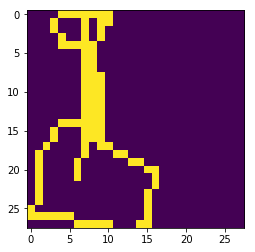

In [376]:
plt.imshow(np.reshape(X_flat[0], (28,28)))

In [141]:
# from keras.models import load_model
# ae_scratch = load_model('ae_scratch-n-500-500-2000-20e.h5')


In [142]:
plt.plot(ae_scratch.history.history['loss'], label='Vanilla AE')

In [143]:
ae_scratch.save('ae_scratch-n-500-500-2000-20e.h5')

In [144]:
ae_scratch.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 2000)              1002000   
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 4002      
_________________________________________________________________
dense_5 (Dense)              (None, 2000)              6000      
_________________________________________________________________
dense_6 (Dense)              (None, 500)               1000500   
_________________________________________________________________
dense_7 (Dense)              (None, 500)               250500    
__________

In [145]:
from keras import backend as K
def get_activations(model, layer, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()], model.layers[layer].output)
    activations = get_activations([X_batch,0])
    return activations

In [146]:
from keras import backend as K

# with a Sequential model
get_3rd_layer_output = K.function([ae_scratch.layers[0].input],
                                  [ae_scratch.layers[3].output])
layer_output = get_3rd_layer_output([X_flat])[0]

In [147]:
layer_output
len(layer_output)

53400

In [219]:
COLORS = [[127,201,127],
        [190,174,212],
        [253,192,134],
        [191,91,23],
        [56,108,176],
        [240,2,127]]
COLORS = [[i/255. for i in j] for j in COLORS]


<IPython.core.display.Javascript object>


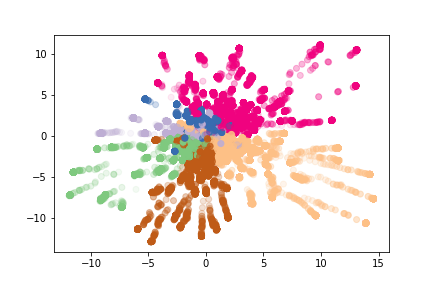

In [220]:
plt.figure()
colors = []
for i, t in zip(info_df['drawing_cat_id'], info_df['t']):
    a = COLORS[int(i)].copy()
    a.append(min(t/80, 1))
    colors.append(a)
    
plt.scatter(layer_output[:,0], layer_output[:,1], 
            color=colors)


In [474]:
N_REVISIONS = int(info_df['t'].max())

info_df['p_x'] = layer_output[:,0]
info_df['p_y'] = layer_output[:,1]


merged_dfs = []

gb = info_df.groupby(by='t', sort=True)
for t in range(N_REVISIONS):
    df_t = gb.get_group(t)
    df_tp1 = gb.get_group(t+1)
    
    df_m = df_t.merge(df_tp1, how='inner', on=['drawing_cat_id', 'drawing_id'])
    df_m = df_m[['drawing_cat_id', 'p_x_x', 'p_y_x', 'p_x_y', 'p_y_y', 'X_index_y']]
    df_m.columns = ['drawing_cat_id', 'p_x_t', 'p_y_t', 'p_x_tp1', 'p_y_tp1', 'X_index']
    merged_dfs.append(df_m.copy())
    


<IPython.core.display.Javascript object>


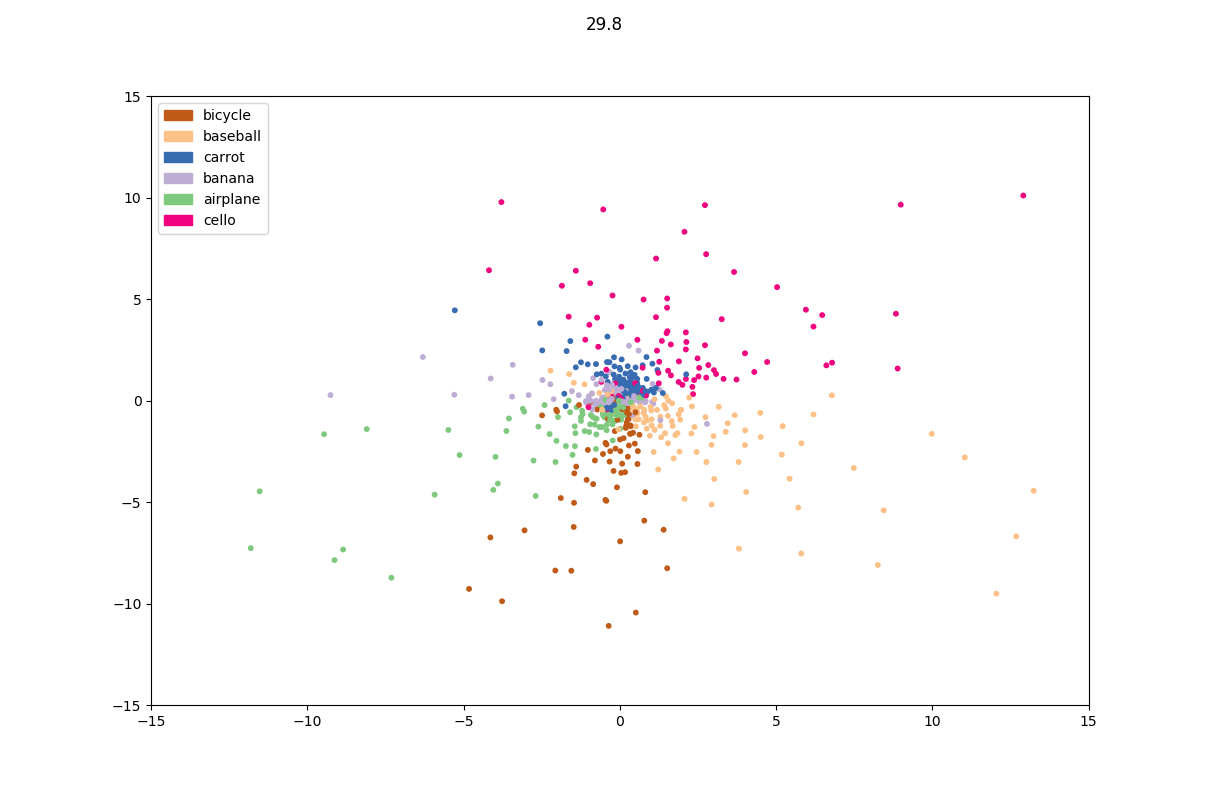

In [465]:
%matplotlib notebook

def draw_revision(ax, df_m, t):
    legend_dict = {CATEGORIES[i]:COLORS[i] for i in range(len(CATEGORIES))}

    offset = t - math.floor(t)
    df_m['p_x'] = (1 - offset) * df_m['p_x_t'] + offset * df_m['p_x_tp1']
    df_m['p_y'] = (1 - offset) * df_m['p_y_t'] + offset * df_m['p_y_tp1']
    ax.scatter(df_m['p_x'], df_m['p_y'], color=[COLORS[int(i)] for i in df_m['drawing_cat_id']], s=10)
    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)
    fig.suptitle(str(t)[:4])
    
    patchList = []
    for key in legend_dict:
            data_key = mpatches.Patch(color=legend_dict[key], label=key)
            patchList.append(data_key)

    plt.legend(handles=patchList)
    fig.canvas.draw()



fig = plt.figure(figsize=(12, 8))
ax = fig.subplots()
# fig.canvas.mpl_connect('pick_event', onpick)

for t in np.arange(20, 30, 0.33):
    plt.cla()
    draw_revision(ax, merged_dfs[math.floor(t)], t)
#     display(merged_dfs[math.floor(t)])
#     time.sleep(0.2)





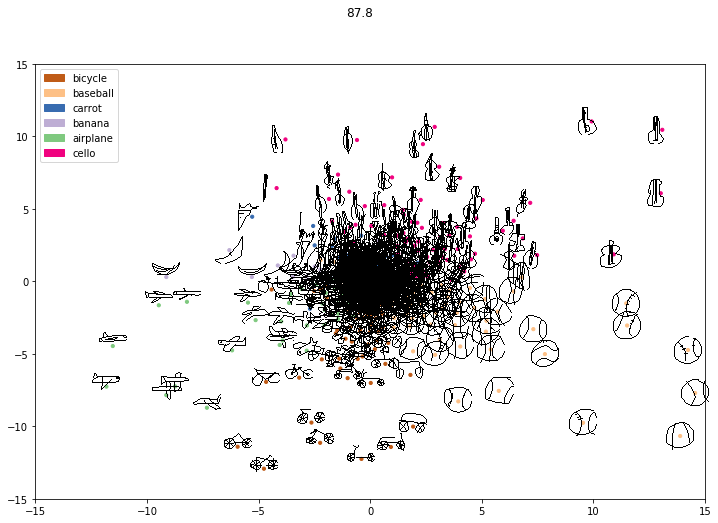

In [475]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def draw_revision_with_images(ax, df_m, X_flat, t):
    legend_dict = {CATEGORIES[i]:COLORS[i] for i in range(len(CATEGORIES))}

    offset = t - math.floor(t)
    df_m['p_x'] = (1 - offset) * df_m['p_x_t'] + offset * df_m['p_x_tp1']
    df_m['p_y'] = (1 - offset) * df_m['p_y_t'] + offset * df_m['p_y_tp1']
    
    my_cmap = cm.binary
    my_cmap.set_under('k', alpha=0)
    
    artists = []
    for _, row in df_m.iterrows():
        im = np.reshape(X_flat[int(row['X_index'])], (28,28))
        im = OffsetImage(im, cmap=my_cmap, clim=[0.9, 1],zoom=1)
        
#         x, y = np.atleast_1d(x, y)
        ab = AnnotationBbox(im, (row['p_x'], row['p_y']), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
        ax.update_datalim(np.column_stack([row['p_x'], row['p_y']]))
        
    ax.autoscale()

    ax.scatter(df_m['p_x'], df_m['p_y'], color=[COLORS[int(i)] for i in df_m['drawing_cat_id']], s=10)
    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)
    fig.suptitle(str(t)[:4])
    
    patchList = []
    for key in legend_dict:
            data_key = mpatches.Patch(color=legend_dict[key], label=key)
            patchList.append(data_key)

    plt.legend(handles=patchList)
    fig.canvas.draw()
    return artists
    
    

fig = plt.figure(figsize=(12, 8))
ax = fig.subplots()
# fig.canvas.mpl_connect('pick_event', onpick)

output_dir = 'anim_{}'.format(time.time())
os.makedirs(output_dir, exist_ok=True)


for i, t in enumerate(np.arange(0, N_REVISIONS, 0.2)):
    plt.cla()
    draw_revision_with_images(ax, merged_dfs[math.floor(t)], X_flat, t)
    fig.savefig('{}/{}.png'.format(output_dir, i))